<a href="https://colab.research.google.com/github/ikszn/V2G-Potential/blob/main/V2GPotentialv11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

STREAMLINED V2G DATA PIPELINE
============================
Clean pipeline: Raw Data → Validated Data → Focused EDA → Scenario Ready

Purpose: Sharp, efficient EDA that informs scenario analysis without overwhelming
Target: Dissertation-quality data pipeline that flows smoothly

# CELL 1: IMPORTS AND SETUP


In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

print("✅ Libraries imported successfully")
print("📊 Ready to process V2G data for dissertation analysis")

✅ Libraries imported successfully
📊 Ready to process V2G data for dissertation analysis


# CELL 2: LOAD YOUR RAW DATA


In [45]:
# Load your charging session data
raw_df = pd.read_csv('/content/evchargedata.csv')  # UPDATE THIS PATH

print(f"📁 Raw data loaded: {raw_df.shape[0]:,} records, {raw_df.shape[1]} columns")
print(f"📅 Columns: {list(raw_df.columns)}")
print("\n🔍 First few rows:")
raw_df.head()

📁 Raw data loaded: 76,698 records, 5 columns
📅 Columns: ['ParticipantID', 'BatteryChargeStartDate', 'BatteryChargeStopDate', 'Starting SoC (of 12)', 'Ending SoC (of 12)']

🔍 First few rows:


,ParticipantID,BatteryChargeStartDate,BatteryChargeStopDate,Starting SoC (of 12),Ending SoC (of 12)
0,GC10,2014-02-16 16:05:00.000,2014-02-16 17:05:00.000,1,11
1,GC10,2014-02-16 18:20:00.000,2014-02-16 19:00:00.000,2,11
2,GC10,2014-02-17 08:10:00.000,2014-02-17 15:57:00.000,4,12
3,GC10,2014-02-18 07:41:00.000,2014-02-18 09:52:00.000,5,8
4,GC10,2014-02-18 15:36:00.000,2014-02-18 15:39:00.000,4,4


# CELL 3: DATA VALIDATION AND BASIC STATS


In [46]:
# Basic validation
total_records = len(raw_df)
unique_vehicles = raw_df['user_id'].nunique() if 'user_id' in raw_df.columns else raw_df.iloc[:, 0].nunique()
missing_data = raw_df.isnull().sum().sum()

print("📊 DATA VALIDATION SUMMARY")
print("=" * 50)
print(f"Total records: {total_records:,}")
print(f"Unique vehicles: {unique_vehicles:,}")
print(f"Missing values: {missing_data:,}")
print(f"Data completeness: {(1 - missing_data/(total_records * len(raw_df.columns)))*100:.1f}%")

if 'start_time' in raw_df.columns:
    print(f"Date range: {raw_df['start_time'].min()} to {raw_df['start_time'].max()}")


📊 DATA VALIDATION SUMMARY
Total records: 76,698
Unique vehicles: 215
Missing values: 0
Data completeness: 100.0%


In [47]:
raw_df

,ParticipantID,BatteryChargeStartDate,BatteryChargeStopDate,Starting SoC (of 12),Ending SoC (of 12)
0,GC10,2014-02-16 16:05:00.000,2014-02-16 17:05:00.000,1,11
1,GC10,2014-02-16 18:20:00.000,2014-02-16 19:00:00.000,2,11
2,GC10,2014-02-17 08:10:00.000,2014-02-17 15:57:00.000,4,12
3,GC10,2014-02-18 07:41:00.000,2014-02-18 09:52:00.000,5,8
4,GC10,2014-02-18 15:36:00.000,2014-02-18 15:39:00.000,4,4
...,...,...,...,...,...
76693,SS206,2015-11-28 18:32:00.000,2015-11-28 21:02:00.000,4,10
76694,ST1074,2015-11-29 14:55:00.000,2015-11-29 19:17:00.000,7,12
76695,ST1062,2015-11-29 06:00:00.000,2015-11-29 09:26:00.000,8,12
76696,BL05,2015-11-28 21:56:00.000,2015-11-29 00:14:00.000,10,12


# CELL 4: DATA PREPROCESSING


In [48]:
print("🔄 Starting data preprocessing...")

# Copy for processing
df = raw_df.copy()

# --- Standardize your original columns (rename) ---
df.rename(columns={
    "ParticipantID": "vehicle_id",
    "BatteryChargeStartDate": "start_time",
    "BatteryChargeStopDate": "end_time",
    "Starting SoC (of 12)": "start_soc",
    "Ending SoC (of 12)": "end_soc",
}, inplace=True)

# Ensure SoC are numeric (in case they came in as strings)
for c in ("start_soc", "end_soc"):
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")


# Convert datetime columns
for col in ['start_time', 'end_time']:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col])
        print(f"✅ Converted {col} to datetime")

# Calculate duration
if 'start_time' in df.columns and 'end_time' in df.columns:
    df['duration_hours'] = (df['end_time'] - df['start_time']).dt.total_seconds() / 3600
    print("✅ Calculated session duration")
elif 'duration_hours' not in df.columns:
    print("⚠️ No time columns found - creating dummy duration")
    df['duration_hours'] = 2.0  # Assume 2 hour average

# Set battery capacity (UPDATE THIS FOR YOUR EV TYPE)
BATTERY_CAPACITY_KWH = 60.0

# Convert SoC scales if needed
for col in ['start_soc', 'end_soc']:
    if col in df.columns:
        max_val = df[col].max()
        if max_val <= 12 and max_val > 1:  # 0-12 scale
            print(f"🔄 Converting {col} from 0-12 to 0-100% scale")
            df[col] = (df[col] / 12) * 100
        elif max_val <= 1:  # 0-1 scale
            print(f"🔄 Converting {col} from 0-1 to 0-100% scale")
            df[col] = df[col] * 100
        else:
            print(f"ℹ️ {col} already in 0-100% scale (max: {max_val:.1f})")

# Calculate V2G potential at different comfort levels
comfort_reserves = [20, 40, 60]  # 20%, 40%, 60% battery reserve
if 'start_soc' in df.columns:
    for reserve in comfort_reserves:
        df[f'v2g_kwh_reserve_{reserve}pc'] = np.maximum(0,
            (df['start_soc'] - reserve) * BATTERY_CAPACITY_KWH / 100)
    print(f"✅ Calculated V2G potential at {comfort_reserves}% reserve levels")
else:
    print("⚠️ No start_soc column - skipping V2G calculation")

# Add time features
if 'start_time' in df.columns:
    df['start_hour'] = df['start_time'].dt.hour
    df['start_weekday'] = df['start_time'].dt.weekday
    df['is_weekend'] = df['start_weekday'] >= 5
    df['start_month'] = df['start_time'].dt.month
    print("✅ Added time-based features")

# Data quality filtering
print("🧹 Applying data quality filters...")
initial_count = len(df)

# Remove invalid sessions
valid_sessions = (
    (df['duration_hours'] >= 0.25) &    # At least 15 minutes
    (df['duration_hours'] <= 48)       # Less than 2 days
)

# Add SoC filters if available
if 'start_soc' in df.columns and 'end_soc' in df.columns:
    valid_sessions = valid_sessions & (
        (df['start_soc'] >= 0) & (df['start_soc'] <= 100) &
        (df['end_soc'] >= 0) & (df['end_soc'] <= 100)
    )

df = df[valid_sessions].copy()

retention_rate = len(df) / initial_count
print(f"✅ Data cleaning complete")
print(f"   Retained: {len(df):,} sessions ({retention_rate*100:.1f}%)")
print(f"   Removed: {initial_count - len(df):,} invalid sessions")

print(f"\n🎯 Ready for EDA with {len(df):,} clean records")

🔄 Starting data preprocessing...
✅ Converted start_time to datetime
✅ Converted end_time to datetime
✅ Calculated session duration
🔄 Converting start_soc from 0-12 to 0-100% scale
🔄 Converting end_soc from 0-12 to 0-100% scale
✅ Calculated V2G potential at [20, 40, 60]% reserve levels
✅ Added time-based features
🧹 Applying data quality filters...
✅ Data cleaning complete
   Retained: 73,117 sessions (95.3%)
   Removed: 3,581 invalid sessions

🎯 Ready for EDA with 73,117 clean records


In [49]:
print("📊 CHARGING BEHAVIOR ANALYSIS")
print("=" * 50)

# Session statistics
print("🔋 SESSION STATISTICS:")
print(f"   Average duration: {df['duration_hours'].mean():.1f} hours")
print(f"   Median duration: {df['duration_hours'].median():.1f} hours")
print(f"   Average start SoC: {df['start_soc'].mean():.1f}%")
print(f"   Average end SoC: {df['end_soc'].mean():.1f}%")

# Calculate energy consumption
df['energy_added_kwh'] = (df['end_soc'] - df['start_soc']) / 100 * BATTERY_CAPACITY_KWH
print(f"   Average energy added: {df['energy_added_kwh'].mean():.1f} kWh/session")

# Temporal patterns
print(f"\n⏰ TEMPORAL PATTERNS:")
most_common_start = df['start_hour'].mode()[0]
print(f"   Most common start time: {most_common_start:02d}:00")

weekend_duration = df[df['is_weekend']]['duration_hours'].mean()
weekday_duration = df[~df['is_weekend']]['duration_hours'].mean()
print(f"   Weekend avg duration: {weekend_duration:.1f}h")
print(f"   Weekday avg duration: {weekday_duration:.1f}h")

# V2G potential summary
print(f"\n⚡ V2G EXPORT POTENTIAL:")
for reserve in comfort_reserves:
    col = f'v2g_kwh_reserve_{reserve}pc'
    eligible = df[df[col] > 0]
    participation_rate = len(eligible) / len(df) * 100
    avg_potential = eligible[col].mean() if len(eligible) > 0 else 0
    total_potential = df[col].sum()

    print(f"   {reserve}% reserve: {participation_rate:.1f}% eligible, {avg_potential:.1f} kWh avg, {total_potential:.0f} kWh total")


📊 CHARGING BEHAVIOR ANALYSIS
🔋 SESSION STATISTICS:
   Average duration: 3.2 hours
   Median duration: 3.0 hours
   Average start SoC: 51.3%
   Average end SoC: 91.2%
   Average energy added: 24.0 kWh/session

⏰ TEMPORAL PATTERNS:
   Most common start time: 17:00
   Weekend avg duration: 3.0h
   Weekday avg duration: 3.3h

⚡ V2G EXPORT POTENTIAL:
   20% reserve: 87.9% eligible, 21.9 kWh avg, 1408260 kWh total
   40% reserve: 67.0% eligible, 15.0 kWh avg, 735950 kWh total
   60% reserve: 33.2% eligible, 12.0 kWh avg, 290300 kWh total


# CELL 6: USER BEHAVIOR CLUSTERING (SIMPLE)


In [50]:
print("\n👥 USER BEHAVIOR SEGMENTATION")
print("=" * 40)

# Simple clustering based on charging patterns
features_for_clustering = ['duration_hours', 'start_hour', 'start_soc']
if all(col in df.columns for col in features_for_clustering):

    # Prepare data for clustering
    X = df[features_for_clustering].fillna(df[features_for_clustering].median())
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # K-means clustering (3 segments)
    kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
    df['user_segment'] = kmeans.fit_predict(X_scaled)

    # Analyze segments
    segment_analysis = df.groupby('user_segment').agg({
        'duration_hours': ['mean', 'count'],
        'start_hour': 'mean',
        'start_soc': 'mean',
        'v2g_kwh_reserve_40pc': 'mean'
    }).round(1)

    print("📊 User Segments Found:")
    for i in range(3):
        segment_data = df[df['user_segment'] == i]
        count = len(segment_data)
        avg_duration = segment_data['duration_hours'].mean()
        avg_start_hour = segment_data['start_hour'].mean()

        # Interpret segments
        if avg_start_hour < 8:
            segment_type = "Early Bird"
        elif avg_start_hour > 16:
            segment_type = "Evening Charger"
        else:
            segment_type = "Midday User"

        print(f"   Segment {i} ({segment_type}): {count} sessions, {avg_duration:.1f}h avg, starts ~{avg_start_hour:.0f}:00")

else:
    print("⚠️ Cannot perform clustering - missing required columns")


👥 USER BEHAVIOR SEGMENTATION
📊 User Segments Found:
   Segment 0 (Midday User): 19408 sessions, 3.1h avg, starts ~8:00
   Segment 1 (Evening Charger): 23079 sessions, 5.1h avg, starts ~19:00
   Segment 2 (Midday User): 30630 sessions, 1.8h avg, starts ~15:00


# CELL 7: CREATE DISSERTATION-READY EDA PLOTS


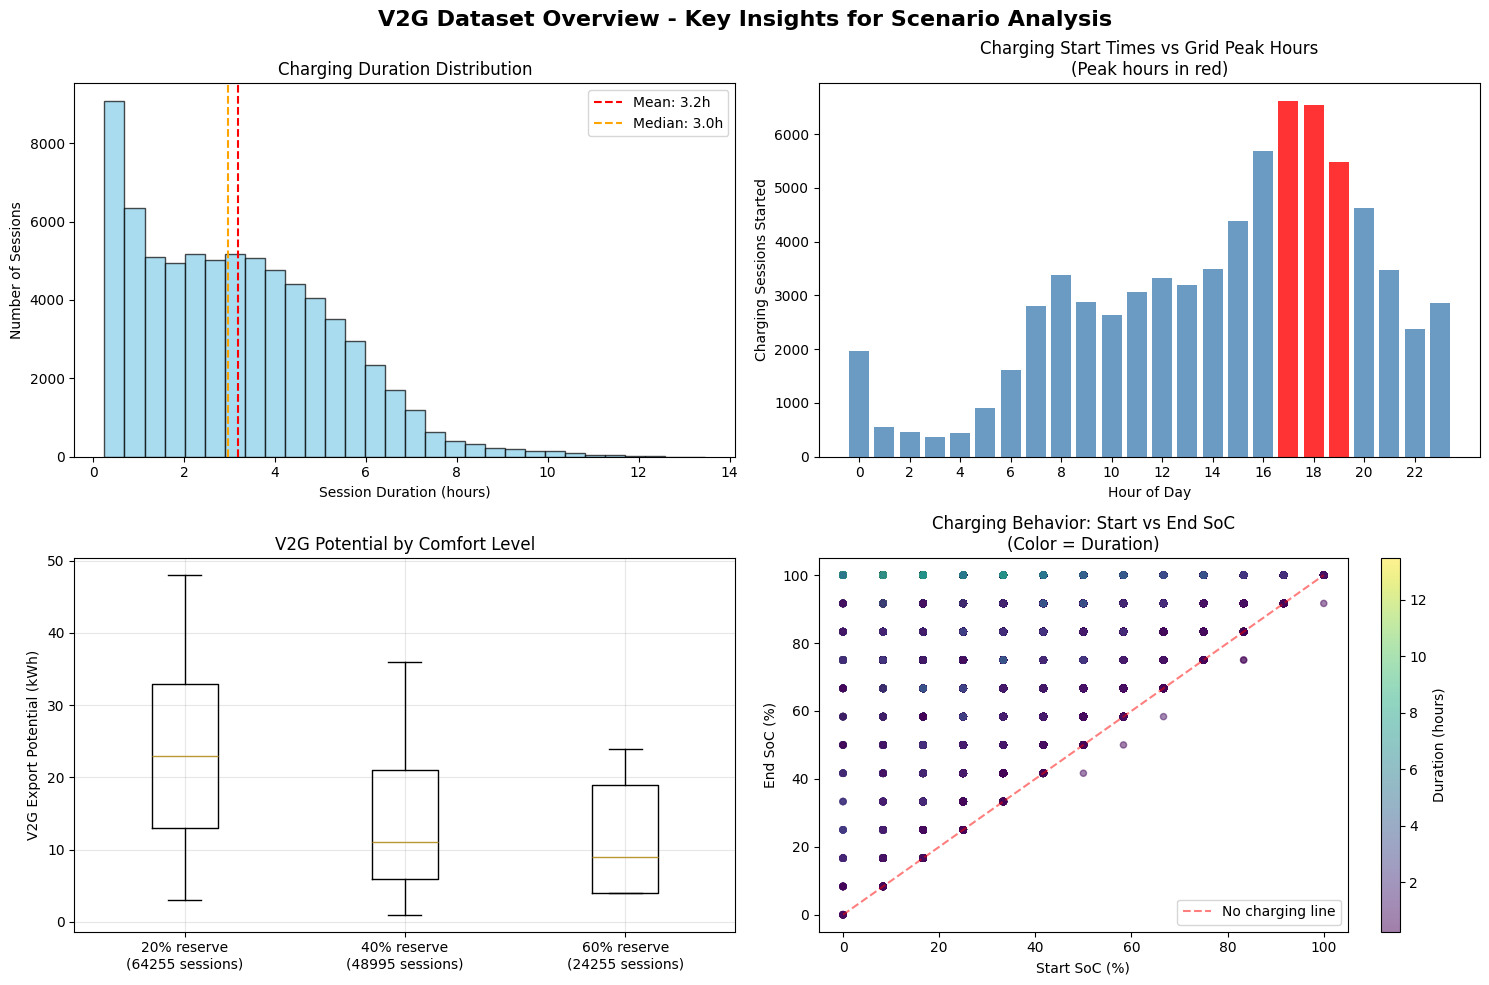

✅ EDA plots generated successfully


In [51]:
# Create focused summary plots for dissertation
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('V2G Dataset Overview - Key Insights for Scenario Analysis', fontsize=16, fontweight='bold')

# Plot 1: Charging duration distribution
ax1 = axes[0, 0]
ax1.hist(df['duration_hours'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
ax1.axvline(df['duration_hours'].mean(), color='red', linestyle='--',
           label=f'Mean: {df["duration_hours"].mean():.1f}h')
ax1.axvline(df['duration_hours'].median(), color='orange', linestyle='--',
           label=f'Median: {df["duration_hours"].median():.1f}h')
ax1.set_xlabel('Session Duration (hours)')
ax1.set_ylabel('Number of Sessions')
ax1.set_title('Charging Duration Distribution')
ax1.legend()

# Plot 2: Hourly charging patterns (grid alignment)
ax2 = axes[0, 1]
hourly_counts = df.groupby('start_hour').size()
peak_hours = [17, 18, 19]  # Typical evening peak
colors = ['red' if h in peak_hours else 'steelblue' for h in hourly_counts.index]
bars = ax2.bar(hourly_counts.index, hourly_counts.values, color=colors, alpha=0.8)
ax2.set_xlabel('Hour of Day')
ax2.set_ylabel('Charging Sessions Started')
ax2.set_title('Charging Start Times vs Grid Peak Hours\n(Peak hours in red)')
ax2.set_xticks(range(0, 24, 2))

# Plot 3: V2G potential at different reserve levels
ax3 = axes[1, 0]
reserve_data = []
reserve_labels = []
for reserve in comfort_reserves:
    col = f'v2g_kwh_reserve_{reserve}pc'
    if col in df.columns:
        eligible_sessions = df[df[col] > 0]
        reserve_data.append(eligible_sessions[col])
        reserve_labels.append(f'{reserve}% reserve\n({len(eligible_sessions)} sessions)')

ax3.boxplot(reserve_data, labels=reserve_labels)
ax3.set_ylabel('V2G Export Potential (kWh)')
ax3.set_title('V2G Potential by Comfort Level')
ax3.grid(True, alpha=0.3)

# Plot 4: SoC patterns (start vs end)
ax4 = axes[1, 1]
scatter = ax4.scatter(df['start_soc'], df['end_soc'], alpha=0.5, s=20, c=df['duration_hours'],
                     cmap='viridis')
ax4.plot([0, 100], [0, 100], 'r--', alpha=0.5, label='No charging line')
ax4.set_xlabel('Start SoC (%)')
ax4.set_ylabel('End SoC (%)')
ax4.set_title('Charging Behavior: Start vs End SoC\n(Color = Duration)')
cbar = plt.colorbar(scatter, ax=ax4)
cbar.set_label('Duration (hours)')
ax4.legend()

plt.tight_layout()
plt.show()

print("✅ EDA plots generated successfully")

# CELL 8: CREATE HOURLY TIME SERIES FOR SCENARIOS


In [52]:
print("🕐 Creating hourly availability time series...")

# Create complete hourly timeline
start_date = df['start_time'].min().floor('H')
end_date = df['end_time'].max().ceil('H')
hourly_timeline = pd.date_range(start_date, end_date, freq='H')

print(f"📅 Timeline: {start_date} to {end_date}")
print(f"📊 Total hours: {len(hourly_timeline):,}")

# Build hourly dataset
hourly_data = []

for timestamp in hourly_timeline:
    # Find sessions active during this hour
    active_sessions = df[
        (df['start_time'] <= timestamp) &
        (df['end_time'] > timestamp)
    ]

    # Calculate hourly metrics
    hour_metrics = {
        'timestamp': timestamp,
        'hour_of_day': timestamp.hour,
        'weekday': timestamp.weekday(),
        'is_weekend': timestamp.weekday() >= 5,
        'active_sessions': len(active_sessions),
        'total_v2g_40pc': active_sessions['v2g_kwh_reserve_40pc'].sum() if len(active_sessions) > 0 else 0,
        'avg_session_duration_remaining': active_sessions['duration_hours'].mean() if len(active_sessions) > 0 else 0
    }

    hourly_data.append(hour_metrics)

# Convert to DataFrame
hourly_df = pd.DataFrame(hourly_data)

# Summary stats
peak_sessions = hourly_df['active_sessions'].max()
peak_timestamp = hourly_df.loc[hourly_df['active_sessions'].idxmax(), 'timestamp']
peak_v2g = hourly_df['total_v2g_40pc'].max()

print(f"✅ Hourly dataset created: {len(hourly_df):,} hourly records")
print(f"📈 Peak concurrent sessions: {peak_sessions} at {peak_timestamp}")
print(f"⚡ Peak V2G potential: {peak_v2g:.1f} kWh at peak hour")


🕐 Creating hourly availability time series...
📅 Timeline: 2013-12-20 10:00:00 to 2015-11-29 20:00:00
📊 Total hours: 17,027
✅ Hourly dataset created: 17,027 hourly records
📈 Peak concurrent sessions: 65 at 2015-01-28 22:00:00
⚡ Peak V2G potential: 506.0 kWh at peak hour


In [53]:
# Check the timeline makes sense
timeline_days = (df['start_time'].max() - df['start_time'].min()).days
expected_hours = timeline_days * 24
print(f"📅 Data spans: {timeline_days} days")
print(f"📊 Expected hours: {expected_hours}")
print(f"📈 Actual hourly records: {len(hourly_df)}")
print(f"🎯 Average sessions per hour: {len(df) / len(hourly_df):.1f}")

📅 Data spans: 709 days
📊 Expected hours: 17016
📈 Actual hourly records: 17027
🎯 Average sessions per hour: 4.3


# CELL 9 : Real Pricing Data

In [64]:
# ===== REAL PRICE DATA: Retail Baseline + Imbalance Sensitivity =====
import os, requests, pandas as pd, numpy as np
from datetime import timedelta

# --- helper: Agile (import/export) → DOW×hour profile in £/kWh ---
def fetch_agile_profile(region_code="C", kind="export", start_date=None, end_date=None) -> pd.DataFrame:
    """
    Fetch Octopus Agile data (import or Agile Outgoing export) for a window.
    Returns DOW×hour mean profile with columns: day_of_week, hour, price_gbp_per_kwh
    """
    url = f"https://agilerates.uk/api/agile_rates_region_{region_code}.json"
    r = requests.get(url, timeout=30); r.raise_for_status()
    data = r.json()
    rates = pd.json_normalize(data["rates"])

    rate_field = "agileOutgoingRate.result.rate" if kind == "export" else "agileRate.result.rate"
    if rate_field not in rates.columns:
        raise KeyError(f"Field '{rate_field}' missing for kind='{kind}'. Available: {list(rates.columns)}")

    df = rates[["deliveryStart", rate_field]].rename(columns={
        "deliveryStart": "timestamp_utc",
        rate_field: "price_p_per_kwh"
    })
    df["timestamp_utc"] = pd.to_datetime(df["timestamp_utc"], utc=True, errors="coerce")
    df["timestamp_uk"]  = df["timestamp_utc"].dt.tz_convert("Europe/London")

    # enforce inclusive window (Europe/London)
    if start_date and end_date:
        t0 = pd.Timestamp(start_date, tz="Europe/London")
        t1 = pd.Timestamp(end_date,   tz="Europe/London") + pd.Timedelta(days=1)
        df = df[(df["timestamp_uk"] >= t0) & (df["timestamp_uk"] < t1)]

    if df.empty:
        raise RuntimeError(f"No Agile data found for kind='{kind}' in {start_date}→{end_date} (region {region_code}).")

    # ensure numeric and convert to £/kWh
    df["price_p_per_kwh"] = pd.to_numeric(df["price_p_per_kwh"], errors="coerce")
    df["price_gbp_per_kwh"] = df["price_p_per_kwh"] / 100.0

    df["day_of_week"] = df["timestamp_uk"].dt.dayofweek
    df["hour"]        = df["timestamp_uk"].dt.hour

    prof = (df.groupby(["day_of_week","hour"])["price_gbp_per_kwh"]
              .mean().reset_index())
    return prof

# --- main: build baseline (retail) and sensitivity (imbalance) ---
def analyze_pricing_landscape(
    region_code: str = "C",
    start_date: str = None,      # e.g. "2024-09-13"
    end_date: str = None,        # e.g. "2025-09-12"
    round_trip_eff: float = 0.90,        # battery round-trip eff
    export_inverter_eff: float = 0.96,   # one-way export inverter eff
    degradation_gbp_per_kwh: float = 0.04
) -> dict:
    """
    Returns a dict with:
      - 'baseline': retail net value profile (Agile Outgoing export vs Agile import)
      - 'sensitivity_imbalance': net value using imbalance as export (if available)
      - plus the component profiles and summary stats
    """
    # default to last 12 months ending yesterday (Europe/London)
    if not start_date or not end_date:
        end_date = (pd.Timestamp.now(tz="Europe/London") - pd.Timedelta(days=1)).strftime("%Y-%m-%d")
        start_date = (pd.Timestamp(end_date) - pd.Timedelta(days=365)).strftime("%Y-%m-%d")

    print("\n5️⃣ PRICE ANALYSIS: Retail Baseline + Imbalance Sensitivity")
    print("—" * 60)
    print(f"📅 Window: {start_date} → {end_date}  (Europe/London)")

    # RETAIL EXPORT (Agile Outgoing)
    export_prof = fetch_agile_profile(region_code, "export", start_date, end_date)\
                    .rename(columns={"price_gbp_per_kwh":"export_price_gbp_per_kwh"})
    e_stats = export_prof["export_price_gbp_per_kwh"].describe()
    print(f"📤 Retail export (Agile Outgoing): mean £/kWh={e_stats['mean']:.3f}  "
          f"min={e_stats['min']:.3f}  max={e_stats['max']:.3f}")

    # RETAIL IMPORT (Agile)
    import_prof = fetch_agile_profile(region_code, "import", start_date, end_date)\
                    .rename(columns={"price_gbp_per_kwh":"import_price_gbp_per_kwh"})
    i_stats = import_prof["import_price_gbp_per_kwh"].describe()
    print(f"📥 Retail import (Agile):        mean £/kWh={i_stats['mean']:.3f}  "
          f"min={i_stats['min']:.3f}  max={i_stats['max']:.3f}")

    # MERGE & BASELINE NET VALUE (per exported kWh)
    merged = export_prof.merge(import_prof, on=["day_of_week","hour"], how="inner")
    eta_rt  = float(np.clip(round_trip_eff, 0.01, 1.0))
    eta_out = float(np.clip(export_inverter_eff, 0.50, 1.0))

    def net_row(r):
        revenue = eta_out * r["export_price_gbp_per_kwh"]
        buy_kwh = 1.0 / eta_rt
        cost    = buy_kwh * r["import_price_gbp_per_kwh"]
        return revenue - cost - degradation_gbp_per_kwh

    merged["net_value_gbp_per_export_kwh"] = merged.apply(net_row, axis=1)
    nv = merged["net_value_gbp_per_export_kwh"].describe()
    pos_hours = int((merged["net_value_gbp_per_export_kwh"] > 0).sum())
    print(f"💷 Baseline net after losses & degradation: mean={nv['mean']:.3f}  "
          f"min={nv['min']:.3f}  max={nv['max']:.3f}  >0 hours: {pos_hours}/168")

    results = {
        "window": {"start": start_date, "end": end_date},
        "retail_export": {
            "source": "Octopus Agile Outgoing",
            "mean_price": float(e_stats["mean"]),
            "profile": export_prof
        },
        "retail_import": {
            "source": "Octopus Agile",
            "mean_price": float(i_stats["mean"]),
            "profile": import_prof
        },
        "baseline": {  # retail baseline net
            "round_trip_eff": eta_rt,
            "export_inverter_eff": eta_out,
            "degradation_gbp_per_kwh": float(degradation_gbp_per_kwh),
            "mean_net": float(nv["mean"]),
            "positive_hours": pos_hours,
            "profile": merged[["day_of_week","hour","net_value_gbp_per_export_kwh"]]
        }
    }

    # IMBALANCE SENSITIVITY (typo-safe + key check)
    print("⚡ Imbalance sensitivity:")
    bmrs_key = os.getenv("BMRS_API_KEY", "").strip()
    # Accept either correct or misspelled class name
    mgr = globals().get("ImbalancePricingManager") or globals().get("ImbalancedPricingManager")
    imbalance_prof = None
    if bmrs_key and bmrs_key.upper() not in {"YOUR_BMRS_KEY","REPLACE_ME"} and mgr is not None:
        try:
            imb = mgr.fetch_imbalance_prices(
                api_key=bmrs_key, start_date=start_date, end_date=end_date, price_choice="mid"
            )
            # Ensure 7×24 grid; compute DOW×hour mean if raw is many days
            if {"day_of_week","hour","imbalance_price_gbp_per_kwh"}.issubset(imb.columns):
                imbalance_prof = (imb.groupby(["day_of_week","hour"], as_index=False)
                                    .agg(imbalance_price_gbp_per_kwh=("imbalance_price_gbp_per_kwh","mean")))
                m = float(imbalance_prof["imbalance_price_gbp_per_kwh"].mean())
                print(f"   ✅ Imbalance DOW×hour profile ready; mean £/kWh≈{m:.3f}")
            else:
                print("   ⚠️ Imbalance data shape unexpected; skipping sensitivity.")
        except Exception as e:
            print(f"   ⚠️ Imbalance fetch failed: {e} (sensitivity skipped)")
    else:
        print("   ℹ️ No BMRS key or manager not defined; skipping sensitivity.")

    if imbalance_prof is not None:
        sens = (imbalance_prof
                  .merge(import_prof, on=["day_of_week","hour"], how="left")
                  .rename(columns={"imbalance_price_gbp_per_kwh":"export_price_gbp_per_kwh"}))
        sens["net_value_gbp_per_export_kwh"] = sens.apply(net_row, axis=1)
        snv = sens["net_value_gbp_per_export_kwh"].describe()
        spos = int((sens["net_value_gbp_per_export_kwh"] > 0).sum())
        print(f"   💡 Sensitivity (imbalance export): mean={snv['mean']:.3f}  "
              f"min={snv['min']:.3f}  max={snv['max']:.3f}  >0 hours: {spos}/168")

        results["sensitivity_imbalance"] = {
            "mean_net": float(snv["mean"]),
            "positive_hours": spos,
            "profile": sens[["day_of_week","hour","net_value_gbp_per_export_kwh"]]
        }
    else:
        results["sensitivity_imbalance"] = None

    # Quick summary for dashboards
    results["summary"] = {
        "baseline_mean_net": results["baseline"]["mean_net"],
        "baseline_pos_hours": results["baseline"]["positive_hours"],
        "retail_export_mean": results["retail_export"]["mean_price"],
        "retail_import_mean": results["retail_import"]["mean_price"],
        "sensitivity_mean_net": (results["sensitivity_imbalance"]["mean_net"]
                                 if results["sensitivity_imbalance"] else None)
    }
    return results


# CELL 10: Price hourly V2G with retail baseline


In [65]:
import requests
import pandas as pd
from datetime import datetime, timedelta

class OctopusAgileOnly:
    """
    Fetch Octopus Agile half-hourly retail prices (inc. VAT) from the public API.
    - Returns: timestamp_utc, agile_price_gbp_per_kwh (+ convenience gbp_per_mwh)
    - Fully paginated; no fallbacks/synthetic data.
    """

    def __init__(self):
        self.agile = None
        self.summary = {}

    def get_agile(self, start_date, end_date,
                  product_code="AGILE-18-02-21",
                  tariff_code="E-1R-AGILE-18-02-21-C",
                  page_size=2500):
        """
        Pull Agile 'standard-unit-rates' between [start_date, end_date].
        If your region uses a different tariff suffix, pass the right tariff_code.
        """
        base = (
            f"https://api.octopus.energy/v1/products/{product_code}/"
            f"electricity-tariffs/{tariff_code}/standard-unit-rates/"
        )
        params = {
            "period_from": pd.Timestamp(start_date).isoformat(),
            "period_to":   pd.Timestamp(end_date).isoformat(),
            "page_size":   page_size,
        }

        rows, url = [], base
        while True:
            r = requests.get(url, params=params, timeout=60)
            r.raise_for_status()
            js = r.json()
            for res in js.get("results", []):
                ts = pd.to_datetime(res["valid_from"], utc=True)
                price_gbp_per_kwh = float(res["value_inc_vat"]) / 100.0  # p/kWh -> £/kWh
                rows.append({
                    "timestamp_utc": ts,
                    "agile_price_gbp_per_kwh": price_gbp_per_kwh,
                })
            next_url = js.get("next")
            if not next_url:
                break
            url, params = next_url, None  # 'next' is a full URL

        df = (pd.DataFrame(rows)
              .drop_duplicates("timestamp_utc")
              .sort_values("timestamp_utc")
              .reset_index(drop=True))

        # clip strictly to the requested window
        mask = (df["timestamp_utc"] >= pd.Timestamp(start_date, tz="UTC")) & \
               (df["timestamp_utc"] <= pd.Timestamp(end_date, tz="UTC"))
        df = df.loc[mask].reset_index(drop=True)

        # convenience: £/MWh
        df["agile_price_gbp_per_mwh"] = df["agile_price_gbp_per_kwh"] * 1000.0

        self.agile = df
        print(f"✅ Agile rows: {len(df)} | Range: {df['timestamp_utc'].min()} → {df['timestamp_utc'].max()}")
        return df

    def summarize(self):
        """Quick stats from the fetched Agile series."""
        if self.agile is None or self.agile.empty:
            raise ValueError("Fetch Agile data first with get_agile().")
        r = self.agile.copy()
        r["hour"] = r["timestamp_utc"].dt.hour
        peak_hours = [17, 18, 19, 20]
        off_peak = [1, 2, 3, 4, 5]

        s = {
            "avg_gbp_per_kwh": r["agile_price_gbp_per_kwh"].mean(),
            "std_gbp_per_kwh": r["agile_price_gbp_per_kwh"].std(),
            "min_gbp_per_kwh": r["agile_price_gbp_per_kwh"].min(),
            "max_gbp_per_kwh": r["agile_price_gbp_per_kwh"].max(),
            "peak_avg": r[r["hour"].isin(peak_hours)]["agile_price_gbp_per_kwh"].mean(),
            "offpeak_avg": r[r["hour"].isin(off_peak)]["agile_price_gbp_per_kwh"].mean(),
        }
        s["spread"] = s["peak_avg"] - s["offpeak_avg"]
        self.summary = s
        print(
            f"📊 Agile avg £/kWh: {s['avg_gbp_per_kwh']:.3f} | "
            f"peak {s['peak_avg']:.3f} | off-peak {s['offpeak_avg']:.3f} | "
            f"spread {s['spread']:.3f} | vol (std) {s['std_gbp_per_kwh']:.3f}"
        )
        return s


In [66]:
octo = OctopusAgileOnly()
octo.get_agile("2025-06-15", "2025-09-13",
               product_code="AGILE-18-02-21",
               tariff_code="E-1R-AGILE-18-02-21-C")
summary = octo.summarize()
df = octo.agile  # your half-hourly series


✅ Agile rows: 4318 | Range: 2025-06-15 00:00:00+00:00 → 2025-09-12 22:30:00+00:00
📊 Agile avg £/kWh: 0.169 | peak 0.238 | off-peak 0.143 | spread 0.095 | vol (std) 0.074
